In [10]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [12]:
# downloading the dataset from kaggle
!kaggle competitions download -c fake-news


 93% 43.0M/46.5M [00:03<00:00, 18.6MB/s]
100% 46.5M/46.5M [00:03<00:00, 14.6MB/s]


In [13]:
# unzip the zipped folder
import zipfile
zip_ref = zipfile.ZipFile('/content/fake-news.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [14]:
# importing the dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Dense,Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
import nltk
import re
from wordcloud import WordCloud
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem.porter import PorterStemmer # for Stemming. Can also use Lematization.
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [15]:
df_train = pd.read_csv('/content/train.csv')

In [16]:
df_train.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [17]:
df_train['label'].value_counts()

1    10413
0    10387
Name: label, dtype: int64

In [18]:
df_train.shape

(20800, 5)

In [19]:
df_train.isnull().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

In [20]:
df_train=df_train.dropna()

In [21]:
df_train.isnull().sum()

id        0
title     0
author    0
text      0
label     0
dtype: int64

In [22]:
# get the independent feature
X = df_train.drop(['label','id'], axis=1)

In [23]:
X.head()

,title,author,text
0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...
2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ..."
3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...
4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...


In [24]:
# lets combine title and author and create a new column 'combined'
X['combined'] = X['title'] + " " + X['author']

In [25]:
X.head()

,title,author,text,combined
0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,House Dem Aide: We Didn’t Even See Comey’s Let...
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,"FLYNN: Hillary Clinton, Big Woman on Campus - ..."
2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",Why the Truth Might Get You Fired Consortiumne...
3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,15 Civilians Killed In Single US Airstrike Hav...
4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,Iranian woman jailed for fictional unpublished...


In [26]:
# getting independent feature
y = df_train["label"]

In [27]:
# Lets check the shape of X and y
print("The shape of X is ", X.shape)
print("The shape of y is ", y.shape)

The shape of X is  (18285, 4)
The shape of y is  (18285,)


In [28]:
# Exploratory Data Analysis

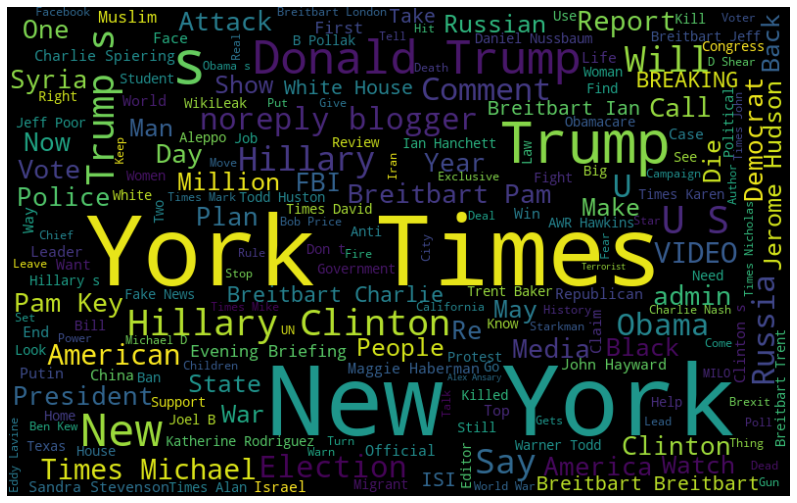

In [29]:
# visualize the frequent words
all_words = " ".join([sentence for sentence in X['combined']])
wordcloud = WordCloud(width = 800, height = 500, random_state=40, max_font_size = 100).generate(all_words)

# plot the graph
plt.figure(figsize=(15,9))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

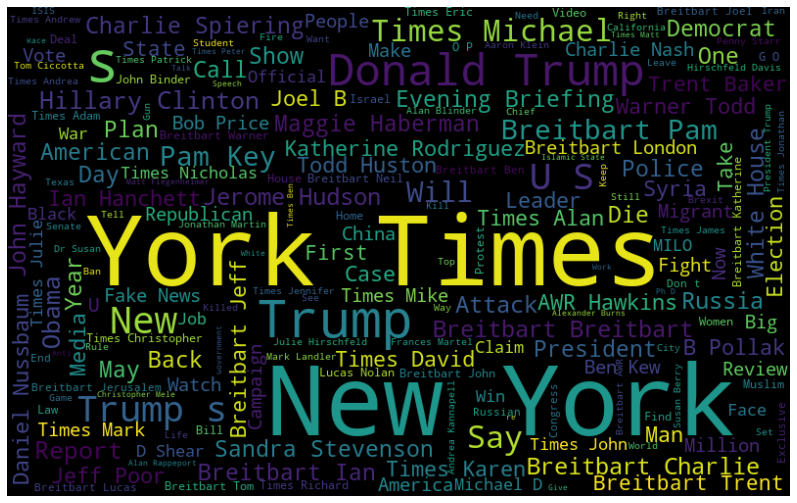

In [30]:
# visualize the frequent words in authentic news
all_words = " ".join([sentence for sentence in X['combined'][y==0]])
wordcloud = WordCloud(width = 800, height = 500, random_state=40, max_font_size = 100).generate(all_words)

# plot the graph
plt.figure(figsize=(15,9))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

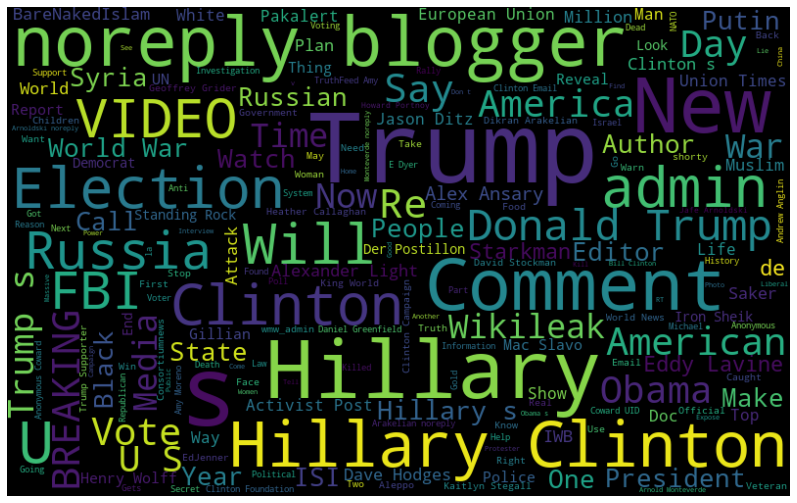

In [31]:
# visualize the frequent words in fake news
all_words = " ".join([sentence for sentence in X['combined'][y==1]])
wordcloud = WordCloud(width = 800, height = 500, random_state=40, max_font_size = 100).generate(all_words)

# plot the graph
plt.figure(figsize=(15,9))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [32]:
# lets count the number of fake news and authentic news
y.value_counts()

0    10361
1     7924
Name: label, dtype: int64

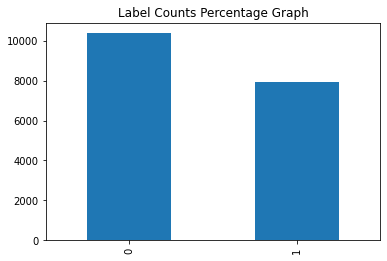

In [33]:
y.value_counts().plot(kind='bar', title='Label Counts Percentage Graph')

In [34]:
# Declaring the vocabulary size
voc_size = 10000

In [35]:
# One Hot Representation

In [36]:
# lets make a copy of the original dataset and do the changes
X_copy = X.copy()

In [37]:
X_copy.reset_index(inplace=True)

In [38]:
X_copy.head()

,index,title,author,text,combined
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,House Dem Aide: We Didn’t Even See Comey’s Let...
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,"FLYNN: Hillary Clinton, Big Woman on Campus - ..."
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",Why the Truth Might Get You Fired Consortiumne...
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,15 Civilians Killed In Single US Airstrike Hav...
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,Iranian woman jailed for fictional unpublished...


In [39]:
# Dataset Preprocessing
def text_cleansing(data):
    ps = PorterStemmer() # initializing the porter stemmer
    corpus = [] # list to append the cleaned corpus
    for i in range(len(data)):
        result = re.sub("[^a-zA-Z]"," ",X_copy["combined"][i]) # This will replace any character other than a-zA-Z with " "
        result = result.lower() # lower casing the text
        result = result.split()
        # the code below will stem those words which are not 'stopwords' 
        result = [ps.stem(word) for word in result if not word in stopwords.words('english')]
        clean_text = " ".join(result)
        corpus.append(clean_text)   
    return corpus

In [40]:
# calling the text_cleansing function
cleaned_text = text_cleansing(X_copy)

In [41]:
# lets see the cleaned text
cleaned_text

['hous dem aid even see comey letter jason chaffetz tweet darrel lucu',
 'flynn hillari clinton big woman campu breitbart daniel j flynn',
 'truth might get fire consortiumnew com',
 'civilian kill singl us airstrik identifi jessica purkiss',
 'iranian woman jail fiction unpublish stori woman stone death adulteri howard portnoy',
 'jacki mason hollywood would love trump bomb north korea lack tran bathroom exclus video breitbart daniel nussbaum',
 'beno hamon win french socialist parti presidenti nomin new york time alissa j rubin',
 'back channel plan ukrain russia courtesi trump associ new york time megan twohey scott shane',
 'obama organ action partner soro link indivis disrupt trump agenda aaron klein',
 'bbc comedi sketch real housew isi caus outrag chri tomlinson',
 'russian research discov secret nazi militari base treasur hunter arctic photo amando flavio',
 'us offici see link trump russia jason ditz',
 'ye paid govern troll social media blog forum websit anotheranni',
 'major

In [42]:
# one hot representation
onehot_rep = [one_hot(words, voc_size) for words in cleaned_text]

In [43]:
# lets see the one hot representation
print(onehot_rep)
# this gives the indexes at which the word is present in the vocab

[[2686, 2921, 3271, 9073, 1887, 6014, 2535, 3024, 2918, 7096, 3059, 8304], [2828, 5874, 7714, 4580, 2219, 3445, 6424, 4987, 4052, 2828], [6135, 3853, 9080, 3749, 5703, 8907], [5402, 8447, 380, 647, 3725, 1883, 6465, 6866], [8038, 2219, 4907, 9163, 8691, 7816, 2219, 2032, 1734, 2063, 8314, 5133], [9091, 5549, 5932, 4610, 1373, 8080, 3838, 1781, 3194, 308, 5330, 5374, 177, 1428, 6424, 4987, 6009], [7482, 4407, 2665, 3861, 4233, 9004, 4526, 8533, 6138, 5941, 6792, 8564, 4052, 43], [1089, 6493, 2164, 2750, 6384, 345, 8080, 997, 6138, 5941, 6792, 9092, 8438, 4723, 4986], [1497, 9652, 8807, 1845, 8271, 8698, 4375, 3501, 8080, 6604, 6270, 4292], [7967, 9901, 9373, 7007, 3231, 2288, 5388, 8880, 5699, 6613], [1404, 6577, 2709, 7645, 9758, 4954, 6921, 592, 2011, 1926, 3093, 703, 5968], [647, 7241, 1887, 8698, 8080, 6384, 3024, 3734], [2037, 2325, 9177, 6609, 4544, 4551, 3702, 8837, 7682, 3496], [7687, 600, 3039, 5440, 9647, 7813, 8531, 6138, 5941, 6792, 9557, 4661], [4421, 8287, 9925, 126, 2368,

In [44]:
# Embedding Representaion

In [45]:
# As the lenght of the sentence will vary. We well pad 0's so that they will be of same length
max_len = 25
embedded_text = pad_sequences(onehot_rep, padding = "post", maxlen = max_len)

In [46]:
# lets see the embedded text
print(embedded_text)


[[2686 2921 3271 ...    0    0    0]
 [2828 5874 7714 ...    0    0    0]
 [6135 3853 9080 ...    0    0    0]
 ...
 [7133 7022 2471 ...    0    0    0]
 [3924 6384 1541 ...    0    0    0]
 [8657 7538 1356 ...    0    0    0]]


In [47]:
X_train = np.array(embedded_text)
y_train = np.array(y)

In [48]:
# Model

In [49]:
def build_model():
    embedding_feature = 40
    # model structure
    model = Sequential([
        Embedding(voc_size, embedding_feature, input_length = max_len),
        Dropout(0.2),
        LSTM(100), # LSTM with 100 neurons
        Dropout(0.2),
        Dense(64, activation = "relu"),
        Dropout(0.2),
        Dense(1, activation = "sigmoid")
    ])
    
    model.compile(optimizer="adam", loss = 'binary_crossentropy',
                 metrics = ['accuracy']
                 )
    
    return model

In [50]:
# calling the build model
model = build_model()

In [51]:
# lets check the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 25, 40)            400000    
                                                                 
 dropout (Dropout)           (None, 25, 40)            0         
                                                                 
 lstm (LSTM)                 (None, 100)               56400     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense (Dense)               (None, 64)                6464      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 6

In [52]:
# lets check the shape of training dataset before fitting to the model
print("The shape of X-train is ", X_train.shape)
print("The shape of y_train is ", y_train.shape)

The shape of X-train is  (18285, 25)
The shape of y_train is  (18285,)


In [53]:
# Lets train the model...
history = model.fit(X_train, y_train, epochs = 10, batch_size =100, validation_split =0.2)

Epoch 1/10
147/147 [==============================] - 11s 10ms/step - loss: 0.2668 - accuracy: 0.8570 - val_loss: 0.0609 - val_accuracy: 0.9795
Epoch 2/10
147/147 [==============================] - 1s 8ms/step - loss: 0.0298 - accuracy: 0.9907 - val_loss: 0.0563 - val_accuracy: 0.9847
Epoch 3/10
147/147 [==============================] - 1s 8ms/step - loss: 0.0082 - accuracy: 0.9977 - val_loss: 0.0852 - val_accuracy: 0.9787
Epoch 4/10
147/147 [==============================] - 1s 7ms/step - loss: 0.0034 - accuracy: 0.9990 - val_loss: 0.0515 - val_accuracy: 0.9877
Epoch 5/10
147/147 [==============================] - 1s 7ms/step - loss: 0.0028 - accuracy: 0.9992 - val_loss: 0.0956 - val_accuracy: 0.9800
Epoch 6/10
147/147 [==============================] - 1s 7ms/step - loss: 0.0021 - accuracy: 0.9994 - val_loss: 0.0573 - val_accuracy: 0.9893
Epoch 7/10
147/147 [==============================] - 1s 8ms/step - loss: 0.0013 - accuracy: 0.9995 - val_loss: 0.0824 - val_accuracy: 0.9852
Epoc

<Figure size 432x288 with 0 Axes>

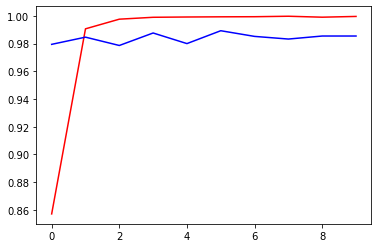

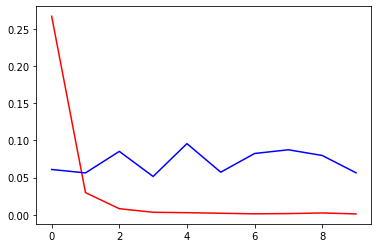

<Figure size 432x288 with 0 Axes>

In [54]:
# Lets plot Accuracy and Loss
acc = history.history["accuracy"]
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label="Training Accuracy")
plt.plot(epochs, val_acc, 'b', label = "Validation Accuracy")

plt.figure()

# Loss
plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label = "Validation Loss")

plt.figure()

In [55]:
# Now, Time to make predictions

In [56]:
df_test = pd.read_csv('/content/test.csv')
df_submit = pd.read_csv('/content/submit.csv')

In [57]:
df_submit.head()

,id,label
0,20800,0
1,20801,1
2,20802,0
3,20803,1
4,20804,1


In [58]:
df_test.head()

,id,title,author,text
0,20800,"Specter of Trump Loosens Tongues, if Not Purse...",David Streitfeld,"PALO ALTO, Calif. — After years of scorning..."
1,20801,Russian warships ready to strike terrorists ne...,NaN,Russian warships ready to strike terrorists ne...
2,20802,#NoDAPL: Native American Leaders Vow to Stay A...,Common Dreams,Videos #NoDAPL: Native American Leaders Vow to...
3,20803,"Tim Tebow Will Attempt Another Comeback, This ...",Daniel Victor,"If at first you don’t succeed, try a different..."
4,20804,Keiser Report: Meme Wars (E995),Truth Broadcast Network,42 mins ago 1 Views 0 Comments 0 Likes 'For th...


In [59]:
# lets do all the preprocessing in this block for the test data
df_test=df_test.dropna()

df_test['combined'] = df_test['title'] + " "+ df_test['author']
df_test_copy = df_test.copy()
cleaned_test_text = text_cleansing(df_test_copy)
onehot_test_rep = [one_hot(words, voc_size) for words in cleaned_test_text]
embedded_text = pad_sequences(onehot_test_rep, padding = "post", maxlen = max_len)
X_test = np.array(embedded_text)

<ipython-input-59-c578a218f65e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['combined'] = df_test['title'] + " "+ df_test['author']


In [61]:
# making predictions
predictions = model.predict(X_test)
predictions = [int(np.round(pred[0])) for pred in predictions]

143/143 [==============================] - 1s 3ms/step


### Create Sample Submission file and Submit

In [70]:
# creating the prediciton dataframe
pred_df = pd.DataFrame(predictions)

In [71]:
df_submit = pd.read_csv('/content/submit.csv')

In [72]:
datasets = pd.concat([df_submit['id'], pred_df], axis =1)

In [74]:
datasets.columns=['id', 'label']

In [75]:
datasets.head()

,id,label
0,20800,1.0
1,20801,0.0
2,20802,1.0
3,20803,1.0
4,20804,1.0


In [76]:
# now getting the submission file
datasets.to_csv('sample_submission.csv', index = False)